In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
from matplotlib.ticker import MultipleLocator
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from cycler import cycler
from PebAcc_Turb import *
from matplotlib import cm

%matplotlib inline

colors = ['#4D4D4D','#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']
          # (black), (blue), (orange), (green), (pink), (brown), (purple), (yellow), (red)
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [2]:
# This cell defines all the relevant functions to calculate the disk surface density
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
G = 6.67259e-8 #cgs
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10

def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st)) [0]*st
    
#def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
#    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
#    t_eta = Re**(-0.5)*t_L
#    t_1_str = st_str(t_1)
#    t_2_str = st_str(t_2)
#    t_12_str = max(t_1_str,t_2_str)
#    t_12_str = max(t_12_str,t_eta)

#    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
#                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

#    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
#                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

#    return np.sqrt(term_1 + term_2)

def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    t_eta = Re**(-0.5)*t_L
    if (t_1 <= t_eta) and (t_2 <= t_eta):
        return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 > t_eta) and (t_1 < t_L):
        y_a = 1.6
        eps = t_1 / t_2
        #print("This is the intermediate regime. Don't use it!")
        #return np.sqrt(2 * y_a - (1 + eps) + 2/(1 + eps) * (1/(1 + y_a) + eps**3/(y_a + eps))) * np.sqrt(t_1)
        return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 >= t_L):
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))
    else:
        print("Something's broken. Probably an issue with St_core.", t_1, t_eta)#, t_eta, t_1, t_2)
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))

def sig_g(a, sig_0, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    gamma = 1
    return sig_0 * ((a/r_crit)**(-gamma)) *np.exp(-(a/r_crit)**(2-gamma))

def t_grow(s, a, f_d, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    T = T_0 * (a**(-3/7))
    c_s = np.sqrt((boltzmann * T)/(2.35*mH))
    Om = np.sqrt((fn.G * m_star * fn.m_sun)/(a * fn.au)**3.)
    v_kep = Om *(a * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    H  = c_s/ Om
    sigma = sig_g(a, sigma_0, params)
    rhoGas = fn.gas_density(sigma, H)
    
    eps_g = 0.5
    M = 1 # Assumed that M_core = 1 earth mass
    st = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=M,sig_in=sigma,temp_in=T)
    m = 4/3 * np.pi * rho_int * s**3
    rho = 1e-2 * sigma/H #f_d * sigma/H
    sig = np.pi * s**2
    v0 = eta*v_kep
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
    Re = (alpha*c_s**2)/(nu*Om) #fn.rey(s, v0, fn.therm_vel(c_s), lambda_mfp)
    v = v0 * d_V_12(t_1=st, t_2=0.5*st, t_L=1, Re=Re)
    
    return m/(eps_g * rho * sig * v) # This is actually the last doubling time. Should I add some prefactor?

def dust_to_gas(disk_age, a, params):    
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    time_grow = disk_age
    sigma = sig_g(a, sigma_0, params)
        
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    H = c_s/Om
    rhoGas = fn.gas_density(sigma, H)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    St_max = (a*fn.au)/(2 * v0 * time_grow)
    # Assumed that M_core = 1 earth mass
    #if a.size > 1:
    s_max = np.zeros(St_max.shape)
    for i, St in enumerate(St_max):
        s_max[i] = st_solver(st=St, alph=alpha, a_au=a[i], m_suns=m_star, m_earths=1, temp_in=T[i], sig_in=sigma[i])
    
    H_d = H * np.sqrt(alpha/(alpha + St_max))
    
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*c_s
    Re = (alpha*c_s**2)/(nu*Om) # Why is this v_turb**2/v_th**2?
    deltaV = np.zeros(St_max.size)
    for idx,t in enumerate(St_max):
        deltaV[idx] = vgas[idx] * d_V_12(t,0.5*t,1,Re[idx])

    f = 0.55
    f_d = (8 * rho_int * s_max * H_d)/(3 * sigma * time_grow * deltaV * f)
    
    t_g_arr = np.zeros(a.shape) # Growth times for largest particle
    for i, a_au in enumerate(a):
        t_g_arr[i] = abs(t_grow(s_max[i], a_au, f_d[i], params)) # The time required to grow a particle to the max particle size
        if abs(t_g_arr[i]) > abs(time_grow):
            f_d[i] = 1e-2
    return f_d
    
def sig_p(f_d, a_PF, a, t, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    Sig_g = sig_g(a, sigma_0, params)
    f_d = 1e-2
    eps_p = 0.5
    eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
    om = np.sqrt(fn.G * m_star * fn.m_sun/(a*fn.au)**3)
    #a_applicable = np.trim_zeros(np.where(a < a_PF, a, 0))
    Sig_p = np.zeros(Sig_g.size) #2**(5/6) * 3**(-7/12) * eps_d**(1/3)/eps_p**(1/2) * f_d**(5/6) * om**(-1/6) * t**(-1/6) * Sig_g
    
    T = T_0 * (a**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    v_kep = om *(a * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    i_PF = np.argmin(abs(a - a_PF))
    Sig_p0_PF = f_d*Sig_g[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * Sig_p0_PF
    lambda_mfp = fn.mean_free_path(fn.mu, Sig_g/(2*c_s/om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * om)
    turbulent = False
    for i, a_au in enumerate(a):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
        
    a_transition = (np.pi/8)**(3/4) * (alpha * np.sqrt(Sig_g) * M_dot * eps_p)/(9 * np.pi**2 * v_kep * (lambda_mfp * rho_int * eta * alpha)**(3/2))
    for i, a_au in enumerate(a):
        if turbulent:
            # Assumes Turbulence dominated relative velocity
            #Sig_p_Ep = ((128 * np.sqrt(2))/(9 * np.pi**2) * (8/np.pi)**(1/4) * np.sqrt(fn.cross/fn.mu) * (Sig_g[i]**(3/2) * c_s[i]**4 * M_dot)/(eta[i]**2 * v_kep[i]**5 * a_au*fn.au * np.sqrt(alpha)))**(1/3)
            Sig_p_Ep = ((256)/(9 * np.pi**2 * eps_p**2) * (8/np.pi)**(1/4) * np.sqrt(lambda_mfp[i] * om[i]/(alpha * c_s[i])) * (Sig_g[i]**2 * c_s[i]**2 * M_dot)/(v_kep[i]**3 * a_au*fn.au))**(1/3)
            Sig_p_St = 8 * np.sqrt(2) * (8/np.pi)**(1/4) * eta[i] * Re[i]**(-1/4) * np.sqrt(rho_int * Sig_g[i] * lambda_mfp[i])/eps_p
        else:
            # Assumes Laminar dominated instead
            Sig_p_Ep = ((64 * alpha * Sig_g[i]**2 * M_dot)/(9 * np.pi**2 * eps_p**2 * v_kep[i] * a_au*fn.au))**(1/3)
            Sig_p_St = 4 * (8/np.pi)**(1/4) * np.sqrt(Sig_g[i] * lambda_mfp[i] * rho_int * alpha * eta[i])/eps_p
        
        Sig_p_Ep = np.minimum(Sig_p_Ep, f_d*Sig_g[i])

        Passed = False
        if (a_au*fn.au > a_transition[i]) or (Passed == True):
            if Sig_p_St < Sig_p_Ep:
                Sig_p[i] = Sig_p_St
            else:
                Sig_p[i] = Sig_p_Ep
            Passed = True
        else:
            Sig_p[i] = Sig_p_St
        #Sig_p[i] = np.minimum(Sig_p_Ep[i], Sig_p_St[i])
        #s_max = (9 * np.sqrt(np.pi/2))/128 * (Sig_p[i]**2)/(alpha * rho_int * eta[i] * Sig_g[i])
        #s_max = (3 * Sig_p[i])/(8 * np.sqrt(2) * rho_int * eta[i])
        #rho_g = Sig_g[i] / (2 * c_s[i]/om[i])
        #lam_mfp = fn.mean_free_path(fn.mu,rho_g,fn.cross)
        #if s_max < 9*lam_mfp/4:
        #    Sig_p[i] = Sig_p_Ep[i]
        #    st_max = (9 * np.pi)/(256) * (Sig_p[i]**2)/(alpha * eta[i] * Sig_g[i]**2) #(3 * np.sqrt(np.pi) * Sig_p[i])/(16 * eta[i] * Sig_g[i])
        #else:
        #    Sig_p[i] = Sig_p_St[i]
        #    st_max = (3 * np.sqrt(np.pi) * Sig_p[i])/(16 * eta[i] * Sig_g[i]) #np.sqrt(np.pi/2)/64 * (Sig_p[i]**2 * fn.cross * om[i])/(fn.mu * c_s[i] * eta[i]**2  * rho_int)
    
    #Sig_p[a_applicable.size:] = 1e-2 * Sig_g[a_applicable.size:]
    return Sig_p

def surface_density(a_arr, t_disk, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    sigma_g = sig_g(a_arr, sigma_0, params)
    f_d = 1e-2
    eps_g = 0.5
    eps_d = eps_g/10
        
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    
    lambda_mfp = fn.mean_free_path(fn.mu, sigma_g/(2*c_s/Om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * Om)
    turbulent = False
    for i, a_au in enumerate(a_arr):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
                
    # Find pebble front location
    #a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_disk**(2/3) / fn.au
    #t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
    if turbulent:
        a_PF = ((9*np.pi * eps_g*eps_d * f_d**2 * np.sqrt((alpha * c_s)/lambda_mfp))/(256 * eta))**(4/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (t_disk**(4/3)) / fn.au
        Om_PF = np.sqrt(fn.G * m_star*fn.m_sun/(a_PF * fn.au)**3)
        t_edge = 256/(9 * np.pi) * eta/(eps_g*eps_d * f_d**2) * np.sqrt((lambda_mfp * Om_PF)/(alpha * c_s))
    else:
        a_PF = ((9 * np.pi * eps_d * eps_g * t_disk)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
        t_edge = (128 * 10**4)/(9 * np.pi * eps_d * eps_g) * alpha * np.sqrt((a_edge * fn.au)**3/(fn.G * m_star * fn.m_sun))
    
    a_interior = np.zeros(t_disk.size)
    sigma_d = np.zeros([t_disk.size, a_arr.size])
    for i,t in enumerate(t_disk):
        a_applicable = np.trim_zeros(np.where(a_arr < a_PF[i], a_arr, 0))
        Sig = sig_g(a_applicable, sigma_0, params)
        sigma_d[i,:a_applicable.size] = sig_p(f_d, a_PF[i], a_applicable, t, params)
        sigma_d[i,a_applicable.size:] = f_d * sigma_g[a_applicable.size:]
        
        T = T_0 * (a_applicable**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        
        if a_PF[i] > a_edge: #np.amax(a_arr):
            # If in Powell et al. 2017 regime, find drift time for maximally size particle
            if a_interior[i-1] != 0:
                a = a_interior[i-1]
                j = np.argmin(abs(a - a_applicable))
            else:
                a = a_edge
                #a = a_applicable[j]
                #t_edge = 0.99 * t # Modified to give non-zero time to drift the 1st time
                
            j = np.argmin(abs(a - a_applicable))
            Sig = sig_g(a, sigma_0, params)
            T = T_0 * (a**(-3/7))
            c_s = np.sqrt((boltzmann*T)/(2.35*mH))
            Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
            v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
            eta = (c_s)**2/(2*(v_kep)**2)
            v0 = eta * v_kep
            
            s = 3*np.sqrt(2)/16 * sig_p(f_d, a_PF[i], a_applicable, t, params)/(eta*rho_int)
            St = st_rad(rad=s[j],alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T) #np.sqrt(3)/8 * eps_p/eta * sig_p(sigma_g, m_star, f_d, a_PF[i], a_arr, t)/sigma_g # Max particle size for all a, at t=t_edge
            v_drift = - 2 * v0 * (St/(1 + St**2))
            if i != 0:
                t_old = max(t_edge, t_disk[i-1])
                t_diff = t - t_old
            else: 
                t_diff = 0
                t_old = 0.99*t_edge
 
            j = np.argmin(abs(a_edge - a_arr))
            st_edge = st_rad(rad=s[j],alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T) # The maximum St at the edge of the disk, when the pebble front hits the disk edge
            s_edge = st_solver(st=st_edge, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            t_diff_arr = np.linspace(t_old, t, 1000)
            a_diff_arr = np.zeros(t_diff_arr.size)
            for k, t_d in enumerate(t_diff_arr):
                if k == 0:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                elif a_drifted < a:
                    T = T_0 * (a_new**(-3/7))
                    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                    eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                    v0 = eta * v_kep
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                else:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
                if k == 0:
                    a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                    a_drifted = abs(a_diff_arr[0])
                    a_new = a - a_drifted
                elif a_drifted < a:
                    a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                    a_drifted = a_drifted + abs(a_diff_arr[k])
                    a_new = a - a_drifted
                else:
                    a_new = 0.0001
            # Finds the locations to which maximally sized particles have drifted by new disk time
            a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

            a_updated = np.trim_zeros(np.where(a_applicable > a_interior[i], a_applicable, 0))
            sigma_g_updated = np.trim_zeros(np.where(a_applicable > a_interior[i], sigma_g[:a_applicable.size], 0))
            a_old = np.trim_zeros(np.where(a_applicable <= a_interior[i], a_applicable, 0))
            if a_old.size == 0:
                sigma_d[i] = dust_to_gas(t, a_updated, params) * sigma_g_updated
            else:
                sigma_g_old = np.trim_zeros(np.where(a_applicable <= a_interior[i], sigma_g[:a_applicable.size], 0))
            
                sigma_d_updated = dust_to_gas(t, a_updated, params) * sigma_g_updated
                sigma_d_old = sig_p(f_d, a_PF[i], a_old, t, params)
                sigma_d[i, :a_applicable.size] = np.append(sigma_d_old, sigma_d_updated) #dust_to_gas(t, a_arr, params) * sigma_g
        else:
            sigma_d[i,:a_applicable.size] = sig_p(f_d, a_PF[i], a_applicable, t, params)
    #print(a_interior)
    return [sigma_g, sigma_d]

In [3]:
# MMSN params
params = np.loadtxt("mmsn_params.txt")
print(params)
# M_star, T_0, Sig_0, R_crit, alpha, t_disk

[1.0000e+00 1.5000e+02 3.4300e+02 1.0000e+01 4.0000e-04 3.1536e+13]


In [9]:
t_array = np.logspace(-2,0, 8) * 3.154e13
a_array = np.logspace(-1, 2, 300)

params = 200, 1, 375, 20, 1.6, 1e-4, 100
#params = 150, 1, 343, 10, 1.6, 4e-4, 100 # MMSN params
T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
f_d = 1e-2

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
        
T = T_0 * (a_array**(-3/7))
c_s = np.sqrt((boltzmann*T)/(2.35*mH))
Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au)**3)
v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au))
eta = (c_s)**2/(2*(v_kep)**2)
lambda_mfp = fn.mean_free_path(fn.mu, Sig_gas/(2*c_s/Om), fn.cross)
Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * Om)

turbulent = False
for i, a_au in enumerate(a_array):
    if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
        turbulent = True

if turbulent:
    a_PF_arr = ((9*np.pi * eps_p*eps_d * f_d**2 * np.sqrt((alpha * c_s)/lambda_mfp))/(256 * eta))**(4/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (t_array**(4/3)) / fn.au
else: 
    a_PF_arr = ((9 * np.pi * eps_d * eps_p * t_array)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="Gas surface density")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial solid surface density")
for i,t in enumerate(t_array):
    plt.vlines(a_PF_arr[i], 1e-5, 1e3, color=line_colors[i], linewidth=2, linestyle='-.')
    #plt.loglog(a_array, f_d_array[i]*Sig_gas, label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    plt.loglog(a_array, sig_d_array[i], label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-5,1e3)
plt.legend()

ValueError: operands could not be broadcast together with shapes (300,) (8,) 

In [8]:
# This cell calculates the location of the pebble front as it bounces back from the disk edge
params = [121, 1, 400, 20, 1.6, 1e-5, 100]
T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
a_array = np.logspace(-1, 2, 300)
gamma = 1
#sigma_g = sigma_0 * ((a_array/r_crit)**(-gamma))*np.exp(-(a_array/r_crit)**(2-gamma))
sigma_g = sig_g(a_array, sigma_0, params)
f_d = 1e-2
eps_g = 0.5
eps_d = eps_g/10

t_array = np.logspace(-1,0.5, 8) * 3.154e13
#a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
#t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
a_PF = ((9 * np.pi * eps_d * eps_g * t_array)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
t_edge = (128 * 10**4)/(9 * np.pi * eps_d * eps_g) * alpha * np.sqrt((a_edge * fn.au)**3/(fn.G * m_star * fn.m_sun))
a_drifted = 0
a_interior = np.zeros(t_array.size)
sigma_d = np.zeros([t_array.size, a_array.size])
for i,t in enumerate(t_array):
    if a_PF[i] > a_edge: #np.amax(a_arr):
        # If in Powell et al. 2017 regime, find drift time for maximally size particle
        if a_interior[i-1] != 0:
            a = a_interior[i-1]
        else: a = a_edge

        j = np.argmin(abs(a - a_array))
        gamma = 1.0
        Sig = sig_g(a, sigma_0, params) #sigma_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
        T = T_0 * (a**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        St = np.sqrt(3)/8 * eps_p/eta * sig_p(f_d, a_PF[i], a_array, t, params)/Sig # Max particle size for all a, at t=t_edge
        v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
        if i != 0:
            t_old = max(t_edge, t_array[i-1])
            t_diff = t - t_old
        else: 
            t_diff = 0
            t_old = 0.99*t_edge

        j = np.argmin(abs(a_edge - a_array))
        st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
        s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
        t_diff_arr = np.linspace(t_old, t, 1000)
        a_diff_arr = np.zeros(t_diff_arr.size)
        for k, t_d in enumerate(t_diff_arr):
            if k == 0:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            elif a_drifted < a:
                T = T_0 * (a_new**(-3/7))
                c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                v0 = eta * v_kep
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            else:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            if k == 0:
                a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                a_drifted = abs(a_diff_arr[0])
                a_new = a - a_drifted
            elif a_drifted < a:
                a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                a_drifted = a_drifted + abs(a_diff_arr[k])
                a_new = a - a_drifted
            else:
                a_new = 0.0001
        # Finds the locations to which maximally sized particles have drifted by new disk time
        a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

print(a_interior)

[26.26557715 25.55820707 24.39365955 22.53865345 19.73206333 15.79525148
 10.81508701  5.31091552]


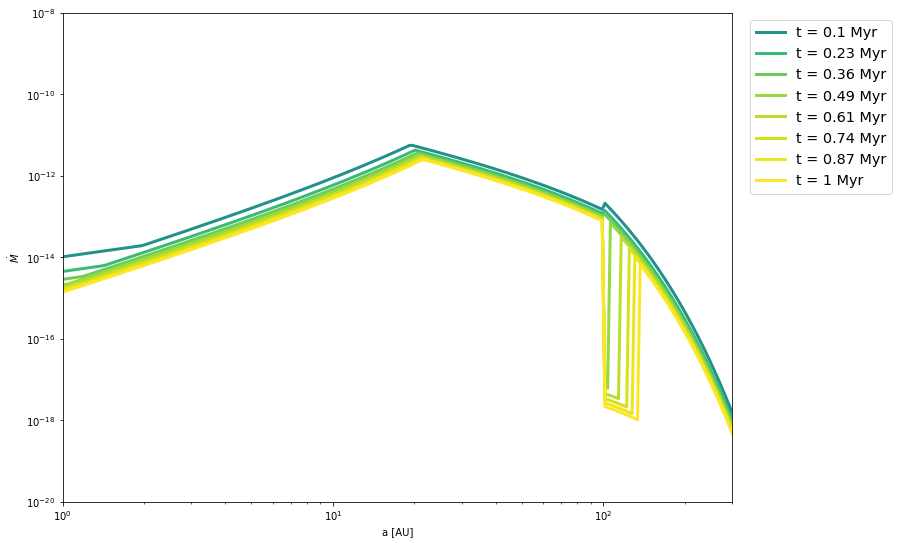

In [10]:
## Plotting m_dot comparison
t_array = np.linspace(0.1, 1, 8) * 3.154e13 #np.logspace(-1,0.5, 16) * 3.154e13
line_colors = [sm.to_rgba(t) for t in t_array]
a_array = np.logspace(0, 3, 300)
M_dot_arr = np.zeros([a_array.size, t_array.size, 2])
sig_d_array = np.zeros([t_array.size, a_array.size])
#params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]
params = 200, 1, 375, 20, 1.6, 1e-6, 100
eps_g = 0.5 # sticking efficiency
eps_d = eps_g/10
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
a_PF_arr = np.zeros(t_array.size)

T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
temp_arr = np.zeros([t_array.size, a_array.size])
for k, t in enumerate(t_array):
    #a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF = ((9 * np.pi * eps_d * eps_g * t)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
    a_PF_ind = np.argmin(abs(a_array - a_PF))
    a_PF_arr[k] = a_PF
    
    turbulent = False
    for j, a_au in enumerate(a_array):
        sig_gas = Sig_gas[j]
        sig_d = sig_d_array[k,j]
        sig_gas_PF = Sig_gas[a_PF_ind]
        temp = T_0*a_au**(-3./7.)
        temp_arr[k,j] = temp
        c_s = fn.sound_speed(temp)
        v_th = np.sqrt(8/np.pi)*c_s
        v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
        Om = v_k/(a_au*fn.au)
        rho_gas = sig_gas * Om/(2*c_s)
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
        lambda_mfp = fn.mean_free_path(fn.mu,rho_gas,fn.cross)
        nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
        Re = (v_g**2)/(nu*Om) #(alpha*c_s**2)/(nu*Om)
        eps_g = 0.5
        if turbulent or (alpha * c_s**2) > (eta**2 * v_k**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True

        if a_PF > a_edge:
            St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=1, temp_in=temp, sig_in=sig_gas)
        else:
            #s = 3*np.sqrt(2)/16 * sig_d/(eta*rho_int)
            #St = 3*np.sqrt(np.pi)/16 * sig_d/(eta * sig_gas) #Om*fn.ts_eps(rho_int, rho_gas, s, v_th) #st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=1,sig_in=sig_gas,temp_in=temp)
            if turbulent:
                # Assuming turbulent velocity instead
                s = (9 * np.sqrt(np.pi/2))/256 * (np.pi/8)**(1/4) * np.sqrt(alpha * c_s/(lambda_mfp * Om)) * (sig_d**2 * v_k**4 * eps_g**2)/(c_s**4 * rho_int * sig_gas)
                St = (9 * np.pi)/(512) * (np.pi/8)**(1/4) * np.sqrt(alpha * c_s/(lambda_mfp * Om)) * (sig_d**2 * v_k**4 * eps_g**2)/(c_s**4 * sig_gas**2)
            else:
                # Assuming laminar velocity is the relative velocity
                s = (9 * np.sqrt(np.pi/2))/128 * (sig_d**2 * eps_g**2)/(alpha * rho_int * eta * sig_gas)
                St = (9 * np.pi)/(256) * (sig_d**2 * eps_g**2)/(alpha * eta * sig_gas**2)
        
        m = 4/3 * np.pi * s**3 * rho_int
        m_dot_global = 4 * np.pi/3 * ((a_PF*fn.au)**2 / t) * f_d * sig_gas_PF / (a_au*fn.au)**2
        m_dot_local = sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (2 * eta * v_k * St) * sig_d/m # Assume laminar velocity
        M_dot_arr[j,k,0] = m_dot_global
        M_dot_arr[j,k,1] = m_dot_local

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.vlines(a_PF_arr[i], 10**-20, 1, color=line_colors[i], linewidth=2, linestyle='-.')
    plt.loglog(a_array, M_dot_arr[:,i,0], linewidth=3, color=line_colors[i], linestyle='--')
    plt.loglog(a_array, M_dot_arr[:,i,1], label='t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i], linestyle='-')
plt.ylabel('$\dot{M}$')#, **axis_font)
plt.xlabel('a [AU]')#, **axis_font)
plt.xlim(1e0, 3e2)
plt.ylim(1e-20, 1e-8)
plt.legend(loc=1, bbox_to_anchor=(1.25, 1., 0., 0.), fontsize='x-large')
plt.show()

(10, 100)

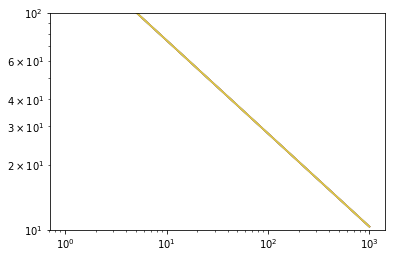

In [7]:
for i,t in enumerate(t_array):
    plt.loglog(a_array, temp_arr[i])
plt.ylim(10,100)

In [15]:
def t_transition(a_arr, t_arr, a_PF, params):
    """TEMPORARY: An attempt to calculate the time at which the disk transitions from the LJ'14 regime to Powell regime."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    sig_gas = sig_g(a_arr, sigma_0, params)
    sig_d = np.zeros([t_arr.size, a_arr.size])
    a_PF_ind = np.zeros(a_arr.size)
    sig_gas_PF = np.zeros(a_arr.size)
    for i,t in enumerate(t_arr):
        sig_d[i] = sig_p(1e-2, a_PF[i], a_arr, t, params)
        index = np.argmin(abs(a_arr - a_PF[i]))
        a_PF_ind[i] = index
        sig_gas_PF[i] = sig_gas[index]
    
    temp = T_0*a_arr**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = fn.vkep(m_star*fn.m_sun, a_arr*fn.au)
    Om = v_k/(a_arr*fn.au)
    rho_gas = sig_gas * Om/c_s
    eta = fn.eta(c_s, v_k)
    v_0 = eta * v_k
    v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    lambda_mfp = fn.mean_free_path(fn.mu,rho_gas,fn.cross)
    nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
    Re = (alpha*c_s**2)/(nu*Om) #Re = (alpha*c_s**2)/(nu*Om)

    #s = 3 *np.sqrt(2)/16 * sig_d/(eta*rho_int)
    #St = Om*fn.ts_eps(rho_int, sig_gas/(2*c_s/Om), s, np.sqrt(8/np.pi)*c_s)
    #St_Ep = (3 * np.sqrt(np.pi) * sig_d)/(16 * eta * sig_gas)
    #St_St = np.sqrt(np.pi/2) * (sig_d**2 * fn.cross * Om)/(64 * fn.mu * c_s * eta**2 * rho_int)
    # Just use Epstein and Laminar for now
    s = (9 * np.sqrt(np.pi/2))/128 * (sig_d**2)/(alpha * rho_int * eta * sig_gas)
    St_Ep = (9 * np.pi)/(256) * (sig_d**2)/(alpha * eta * sig_gas**2)
    St = np.zeros([t_arr.size, a_arr.size])
    for i,t in enumerate(t_arr):
        m_dot_global = 4 * np.pi/3 * (a_PF[i]*fn.au)**2 / t * f_d * sig_gas_PF[i] / (a_arr*fn.au)**2
        m_dot_local = np.zeros(a_arr.size)
        for j,a in enumerate(a_arr):
            if s[i,j] < 9*lambda_mfp[j]/4:
                St[i,j] = St_Ep[i,j]
            else:
                St[i,j] = St_Ep[i,j] #St_St[i,j]
            m = 4/3 * np.pi * s[i,j]**3 * rho_int
            #m_dot_local[j] = sig_d[i,j] * (Om[j]/(2*c_s[j])) * np.sqrt(St[i,j]) * np.pi * s[i,j]**2 * (c_s[j] * d_V_12(t_1=St[i,j],t_2=0.5*St[i,j], Re=Re[j])) * sig_d[i,j]/m
            m_dot_local[j] = sig_d[i,j] * (Om[j]/(2*c_s[j])) * np.sqrt(St[i,j]/alpha) * np.pi * s[i,j]**2 * (2 * eta[j] * v_k[j] * St[i,j]) * sig_d[i,j]/m # Assume laminar velocity
            #if m_dot_global[j] < m_dot_local[j]:
            #    t_transition = t
            #    return t_transition
        if m_dot_global[int(a_PF_ind[i])] < m_dot_local[int(a_PF_ind[i])]: # Use the M_dot just inside the pebble front
            t_transition = t
            break
    return t_transition

# Writing a new version of surface density function, to use the transition time
def surface_density(a_arr, t_disk, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, a_edge = params
    
    sigma_g = sig_g(a_arr, sigma_0, params)
    f_d = 1e-2
    eps_g = 0.5
    
    # Solve the for the transition time
    t_arr = np.logspace(-1,0.5,300)
    a_PF_arr = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_arr**(2/3) / fn.au
    t_trans = t_transition(a_arr, t_arr, a_PF_arr, params)
    a_edge = a_PF_arr[np.argmin(abs(t_arr - t_trans))]
    t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
    
    # Find pebble front location
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_disk**(2/3) / fn.au
    
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    
    a_interior = np.zeros(t_disk.size)
    sigma_d = np.zeros([t_disk.size, a_arr.size])
    for i,t in enumerate(t_disk):
        if t > t_trans: #if a_PF[i] > a_edge:
            # If in Powell et al. 2017 regime, find drift time for maximally size particle
            if a_interior[i-1] != 0:
                a = a_interior[i-1]
            else: a = a_edge
                
            j = np.argmin(abs(a - a_arr))
            Sig = sig_g(a, sigma_0, params)
            T = T_0 * (a**(-3/7))
            c_s = np.sqrt((boltzmann*T)/(2.35*mH))
            Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
            v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
            eta = (c_s)**2/(2*(v_kep)**2)
            v0 = eta * v_kep
            # Assumes Epstein, laminar
            Sig_p = dust_to_gas(t, a_arr, params) * Sig
            s = (9 * np.sqrt(np.pi/2))/128 * (Sig_p[j]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
            St = (9 * np.pi)/(256) * (Sig_p[j]**2 * eps_g**2)/(alpha * eta * Sig**2)
            #s = 3*np.sqrt(2)/16 * sig_p(f_d, a_PF[i], a_arr, t, params)/(eta*rho_int)
            #St = st_rad(rad=s[j],alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (St/(1 + St**2))
            t_old = max(t_edge, t_disk[i-1])
 
            j = np.argmin(abs(a_edge - a_arr))
            st_edge = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T) # The maximum St at the edge of the disk, when the pebble front hits the disk edge
            s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            t_diff_arr = np.linspace(t_old, t, 1000)
            a_diff_arr = np.zeros(t_diff_arr.size)
            for k, t_d in enumerate(t_diff_arr):
                if k == 0:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                elif a_drifted < a:
                    T = T_0 * (a_new**(-3/7))
                    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                    eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                    v0 = eta * v_kep
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                else:
                    st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
                v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
                if k == 0:
                    a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                    a_drifted = abs(a_diff_arr[0])
                    a_new = a - a_drifted
                elif a_drifted < a:
                    a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                    a_drifted = a_drifted + abs(a_diff_arr[k])
                    a_new = a - a_drifted
                else:
                    a_new = 0.0001
            # Finds the locations to which maximally sized particles have drifted by new disk time
            a_interior[i] = a_new

            a_updated = np.trim_zeros(np.where(a_arr > a_interior[i], a_arr, 0))
            sigma_g_updated = np.trim_zeros(np.where(a_arr > a_interior[i], sigma_g, 0))
            a_old = np.trim_zeros(np.where(a_arr <= a_interior[i], a_arr, 0))
            if a_old.size == 0:
                sigma_d[i] = dust_to_gas(t, a_updated, params) * sigma_g_updated
            else:
                sigma_g_old = np.trim_zeros(np.where(a_arr <= a_interior[i], sigma_g, 0))
            
                sigma_d_updated = dust_to_gas(t, a_updated, params) * sigma_g_updated
                sigma_d_old = sig_p(f_d, a_PF[i], a_old, t, params)
                sigma_d[i] = np.append(sigma_d_old, sigma_d_updated)
        else:
            sigma_d[i] = sig_p(f_d, a_PF[i], a_arr, t, params)
    #print(a_interior)
    return [sigma_g, sigma_d]

In [20]:
a_PF_arr = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
print(t_transition(a_array, t_array, a_PF_arr, params) / 3.154e13)

0.1
